# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [2]:
#können nicht einfach importiert werden. Also:
#pip install tqdm
#pip install PyPDF2
#pip install langchain
#pip install sentence-transformers
#pip install faiss-cpu
#pip install matplotlib
#pip install umap-learn
#pip install numpy

#langchain_community.embeddings geht teils nicht. Dann: pip install --upgrade langchain langchain-community

import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [3]:
#* heisst einfach, dass ein PDF von data geladen wird

### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


'Building Competence. Crossing Borders.Retrieval Au'

"""
## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.
"""

In [4]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters

# Initialize a text splitter with specified chunk size and overlap
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

# Display the resulting chunks
chunks


['Building Competence. Crossing Borders.Retrieval Augmented Generation\nTokenization and Embedding\nJasmin Heierli \njasm in.heierli@zhaw.ch / 18.03.2024 RAG Architecture\n2 NLP –Week 4 18.03.2024User Input Data Retrieval\n(Embeddings, \nVektor database)Prompt Injection Large Language Model AnswerData Storage/Source New Problem\n3−Given our user query: What are the first words spoken after landing on the moon?\n−Given a knowledge base (knowledge graph, database, collection of texts…)\n−How canweidentify relevant knowledge base entries ?\nqueryanswerwrong answer\nEuclidian Distance\nCosine of\nangle \nbetween\nvectors\n18.03.2024 NLP –Week 4 Semantics\n4Time flies like an arrow; fruit flies like a banana\nfly: moving through theair.\nfly: a small insect withsmall wings\nhttps://web.stanford.edu/~jurafsky/slp3/6.pdf\nhttps://web.stanford.edu/~jurafsky/slp3/G.pdfSemantics in a nutshell: A fundamental aspect of semantics is the recognition that there is not \nalways a direct connection bet

In [5]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 4
Preview of the first chunk: Building Competence. Crossing Borders.Retrieval Augmented Generation
Tokenization and Embedding
Jasmin Heierli 
jasm in.heierli@zhaw.ch / 18.03.2024 RAG Architecture
2 NLP –Week 4 18.03.2024User Input


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model.

In [6]:
#Ein Tokenizer zerlegt Text in kleinere Einheiten, sogenannte Tokens. Diese Tokens sind typischerweise: Wörter, Wortbestandteile oder einzelne Zeichen
#"Das ist ein Test." Tokens könnten sein: ["Das", "ist", "ein", "Test", "."]

#SentenceTransformersTokenTextSplitter --> ist ein spezialisierter Text-Splitter, der den Tokenizer des angegebenen Modells verwendet.
#model_name="paraphrase-multilingual-MiniLM-L12-v2" --> bedeutet: Es wird der Tokenizer von diesem Multilingualen MiniLM-Modell genutzt.
#tokens_per_chunk=128 --> Der Text wird in Chunks von maximal 128 Tokens aufgeteilt.
#chunk_overlap=0 --> Es gibt keine Überlappung zwischen den Chunks.

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [7]:
#Du hast eine Liste von Textabschnitten (chunks) – und willst diese weiter in kleinere Textteile splitten, basierend auf der Token-Anzahl.

token_split_texts = [] #erstellt leere Liste
for text in chunks:     #Für jeden Textabschnitt (text) in deiner chunks-Liste. wende token_splitter.split_text(text) an – das verwendet deinen vorher definierten Token-basierten Splitter (z. B. in 128-Tokens-große Stücke), und füge die gesplitteten Textstücke zu token_split_texts hinzu (per +=).
    token_split_texts += token_splitter.split_text(text)
print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])   #Zeigt dir das erste Textstück, das per Tokenizer gesplittet wurde.


Total chunks: 19
Building Competence. Crossing Borders.Retrieval Augmented Generation Tokenization and Embedding Jasmin Heierli jasm in.heierli@zhaw.ch / 18.03.2024 RAG Architecture 2 NLP –Week 4 18.03.2024User Input Data Retrieval (Embeddings, Vektor database)Prompt Injection Large Language Model AnswerData Storage/Source New Problem 3−Given our user query: What are the first words spoken after landing on the moon? −Given a knowledge base (knowledge graph,


In [8]:
#zeigt wie ein Textstück in Tokens umgewandelt wird.

#Du lädst das gewählte SentenceTransformer-Modell, inklusive Tokenizer.
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):      #Du gehst die ersten 10 Chunks deiner zuvor gesplitteten Texte durch.
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁Building', '▁Comp', 'et', 'ence', '.', '▁Cross', 'ing', '▁Bord', 'ers', '.', 'Re', 'trie', 'val', '▁Aug', 'mente', 'd', '▁Generation', '▁To', 'ken', 'ization', '▁and', '▁Em', 'be', 'dding', '▁Jasmin', '▁Hei', 'er', 'li', '▁ja', 's', 'm', '▁in', '.', 'hei', 'er', 'li', '@', 'zh', 'aw', '.', 'ch', '▁/', '▁18.', '03.20', '24', '▁RA', 'G', '▁Architect', 'ure', '▁2', '▁N', 'LP', '▁–', 'We', 'ek', '▁4', '▁18.', '03.20', '24', 'U', 'ser', '▁In', 'put', '▁Data', '▁Re', 'trie', 'val', '▁(', 'Em', 'be', 'dding', 's', ',', '▁V', 'ektor', '▁database', ')', 'Pro', 'mp', 't', '▁In', 'je', 'ction', '▁Large', '▁Language', '▁Model', '▁Answer', 'Data', '▁Storage', '/', 'Source', '▁New', '▁Problem', '▁3', '−', 'Gi', 'ven', '▁our', '▁user', '▁que', 'ry', ':', '▁What', '▁are', '▁the', '▁first', '▁words', '▁spoke', 'n', '▁after', '▁landing', '▁on', '▁the', '▁', 'moon', '?', '▁−', 'Gi', 'ven', '▁a', '▁knowledge', '▁base', '▁(', 'know', 'ledge', '▁', '</s>']
Chunk 1: ['<s>', '▁database', ',

In [9]:
#gleich wie oben, aber mit neuem Sprachmodell, explizit für deutsch.

model_name = "Sahajtomar/German-semantic"    #einzige Änderung zu oben: Neues Modell
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'Bu', '##ilding', 'Comp', '##eten', '##ce', '.', 'Cross', '##ing', 'Borde', '##rs', '.', 'Ret', '##rie', '##val', 'Aug', '##mente', '##d', 'Generation', 'Tok', '##eni', '##za', '##tion', 'and', 'Em', '##bed', '##ding', 'Jas', '##min', 'Hei', '##erl', '##i', 'ja', '##sm', 'in', '.', 'hei', '##erl', '##i', '@', 'z', '##haw', '.', 'ch', '/', '18', '.', '03', '.', '202', '##4', 'R', '##AG', 'Archite', '##cture', '2', 'NL', '##P', '–', 'We', '##ek', '4', '18', '.', '03', '.', '202', '##4', '##U', '##ser', 'In', '##put', 'Data', 'Ret', '##rie', '##val', '(', 'Em', '##bed', '##dings', ',', 'Ve', '##ktor', 'dat', '##aba', '##se', ')', 'Prom', '##pt', 'In', '##ject', '##ion', 'Lar', '##ge', 'Lang', '##uage', 'Model', 'Ans', '##wer', '##Dat', '##a', 'Stor', '##age', '/', 'Source', 'New', 'Problem', '3', '##−', '##Gi', '##ven', 'our', 'use', '##r', 'quer', '##y', ':', 'What', 'are', 'the', 'first', 'wor', '##ds', 'sp', '##ok', '##en', 'after', '[SEP]']
Chunk 1: ['[CLS]', 'dat',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [10]:
#In diesem Codeausschnitt werden Text-Chunks in Vektoren (Embeddings) umgewandelt – ein zentraler Schritt in NLP-Anwendungen wie Suche, Clustering oder Klassifikation.

#Embedding ist ein Vektor (also eine Liste von Zahlen), der den inhaltlichen Bedeutungsraum eines Texts in einer numerischen Form abbildet, die ein Modell verstehen kann.

embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")     #Hier erstellst du eine Instanz von HuggingFaceEmbeddings aus langchain, basierend auf dem Modell
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)     #Hier nutzt du stattdessen das SentenceTransformer-Modell (aus vorheriger Zelle, z. B. model = SentenceTransformer(...)) direkt:

/tmp/ipykernel_51285/495563739.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")     #Hier erstellst du eine Instanz von HuggingFaceEmbeddings aus langchain, basierend auf dem Modell


"""
## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.
"""

In [30]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [31]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 19


In [32]:
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [41]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

4
19


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [34]:
#Konkret verwendest du UMAP, um deine hochmodimensionalen Vektoren (z. B. 384-dimensionale Embeddings) in 2D zu transformieren, damit du sie später grafisch darstellen kannst (z. B. mit matplotlib).

#Du trainierst UMAP auf deinen chunk_embeddings.
#chunk_embeddings: Deine Vektoren, z. B. mit Form (24, 384)
#UMAP(...): UMAP ist ein nicht-lineares Reduktionsverfahren, das ähnlich wie t-SNE funktioniert – aber oft schneller und strukturtreuer ist.
#fit(...): Berechnet die 2D-Repräsentation auf Basis aller Embeddings

# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):    #Eine Funktion, die beliebige Embeddings (z. B. auch neue später) in denselben 2D-Raum transformieren kann – basierend auf dem oben gelernten umap_transform.
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))    #Platzhalter für alle 2D-Projektionen (eine Zeile pro Embedding, 2 Spalten → x/y).
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):    #Du projizierst jedes Embedding einzeln in den 2D-Raum und speicherst das Ergebnis.
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings    #Gibt das neue Array mit 2D-Koordinaten zurück – perfekt für Plotting oder Clustering.


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [35]:
# Project the entire dataset embeddings

#Du projizierst alle deine Chunk-Embeddings in den zweidimensionalen Raum, um sie visuell analysieren oder darstellen zu können.

projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/19 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all

Projected dataset embeddings shape: (19, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [ ]:
#Du definierst eine Funktion namens retrieve(...), die für eine Suchanfrage (Query) die ähnlichsten Text-Chunks aus deinem Dokument findet – basierend auf Vektor-Ähnlichkeit im Embedding-Raum.

def retrieve(query, k):    #Die Funktion nimmt zwei Eingaben: query: Ein Text-String, z. B. "Was ist die Energiewende?", k: Anzahl der ähnlichsten Treffer, die zurückgegeben werden sollen (Standard = 5)
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)    #Deine Textanfrage wird in ein Embedding-Vektor umgewandelt – genauso wie du es vorher mit den Chunks gemacht hast.
    distances, indices = index.search(query_embedding, k)      #Hier passiert die eigentliche Suche: index ist ein Vektorsuchindex mit FAISS erstellt, search(...) gibt zurück
    retrieved_texts = [chunks[i] for i in indices[0]]    #Du holst dir die originalen Textstücke (Chunks), die zu den k ähnlichsten Embeddings gehören.
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])    #Du holst dir auch die Embedding-Vektoren dieser Top-k-Treffer.
    return retrieved_texts, retrieved_embeddings, distances[0]    #Rückgabe: die besten Text-Chunks, ihre Embeddings, die zugehörigen Abstände (für Ähnlichkeitsbewertung)

In [51]:
def retrieve(query, k):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances

In [ ]:
query = "What is the most important factor in diagnosing asthma?"
results, result_embeddings, distances = retrieve(query, 3)
print("Retrieved document preview:")
print(results[0][:300])
print(results[1])

Retrieved document preview:
thogonal −There is no natural notion of similarity for one-hot-encoded vectors −They become immensely sparse with a large vocabulary
it. https:// twitter.com /data_monsters https:// web.stanford.edu /~jurafsky /slp3/6.pdf 18.03.2024 NLP –Week 4 Word Embeddings 12An embedding is a short dense vector of a fixed size consisting of floating point numbers. Similar words have a similar encoding. Static embeddings : the same token has always the same embedding Contextual embeddings: different representations for a token depending on its context. The floating point values of the embedding


In [53]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings: 100%|██████████| 1/1 [00:00<0

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

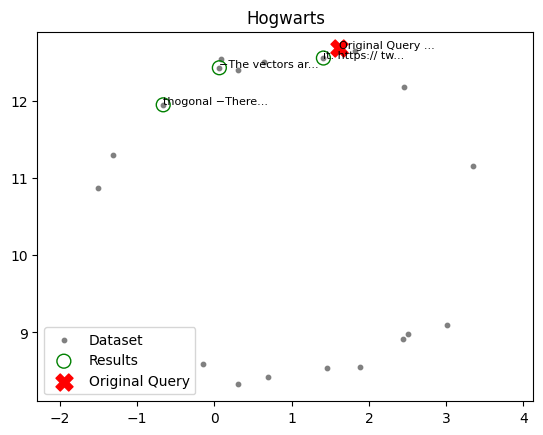

In [54]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Original Query Text'  # Replace with your actual query text if needed
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Hogwarts')
plt.legend()
plt.show()


## Attach Retrieved Results to LLM

- Combine learnings from week 1 with approach from this week to inject your data into prompts and create a simple question answering system